In [19]:
import numpy as np
import pandas as pd
import glob
import tempfile
import os
import subprocess 
import pylab as pl
import seaborn as sbs
from matplotlib_venn import venn2
sbs.set(context='talk')

In [2]:
ls

analysis/  compareSVs_CREST_analysisCombRun.ipynb*  modules/   run_pipeline.sh*
bin/       main.nf*                                 nextflow*  work/


# Prep
After running Crest through analysis.pl comb for both hg38 and hg19 (although it was not necessary to re-run hg19 as only the config files for hg38 were updated). The following steps are taken:
1. reformat the \*.predSV files to bedpe files
2. liftover hg19 coord in the bedpe files to hg38 coord
3. compare the SVs using pairToPair to find overlapping and non-overlapping (missing/extra SVs).
4. pile up SVs events from all samples in each chromosome bin by category of SV (utilizing hg38 chromosome bins and pairToBed)


Thus without lefting over coordinates little overlap is observed

# lifting over breakpoint positions of hg19 to hg38
By using liftover_sv.sh which uses liftover_flatfile.pl to liftover segments with the -interval-interbase option (base-1 assumed in the data) and liftover_bambino.pl for others, posA and posB of hg38 found by CREST were liftover to hg19 and then back to hg38 (to control for liftover artifacts) and hg19 was liftover to hg38 to then compare
## Using pairToPair enforcing strandedness and looking for matches in both

In [3]:
pwd

'/mnt/z/ResearchHome/ProjectSpace/zhanggrp/MethodDevelopment/common/hg38_CREST/ralsalla/hg38_version/crest_compare_newConfigJuly20_2021_wComb/triple_liftover/test_notboth_fordetectingnoMatches'

In [6]:
df3_slop100= pd.read_csv("analysis/bedpe_comp_hg19_to_hg38/summary_all.out", sep="\t") #triple liftover AND making sure bedpe files are 0-based
 
####
####### set which data to use throughout
df_current = df3_slop100

In [7]:
df_current[df_current['NoverlappingSVs'].isnull()]

,pair,Nbreakpnts_hgFrom,Nbreakpnts_hgTo,NoverlappingSVs,Noverlapping_match_type,Noverlapping_discordant_type,EvidenceSummaryForOverlapping_diff,EvidenceSummaryForOverlapping_mid,Nmissing,EvidenceSummaryForMising,Nextra,EvidenceSummaryForExtra


In [8]:
df_current[(df_current['Nmissing']/df_current['Nbreakpnts_hgFrom'])>0.5]

,pair,Nbreakpnts_hgFrom,Nbreakpnts_hgTo,NoverlappingSVs,Noverlapping_match_type,Noverlapping_discordant_type,EvidenceSummaryForOverlapping_diff,EvidenceSummaryForOverlapping_mid,Nmissing,EvidenceSummaryForMising,Nextra,EvidenceSummaryForExtra
57,SJPHCML030001_D1_G1,31,29,16,16,0,0.864948,34.047133,16,148.541238,14,38.08169


In [46]:
np.sqrt(134*142)

137.94201680416305

** skip this if no slop
* because really the reliable is the number of missing and the number of extra (as the Noverlapping can have dupliate matches due to considering the different combination for comparing the two ends simultaneously; i.e. A with A AND B with B OR A with B AND B with A). This is why the number NoverlappingSVs might be higher than the orginal Nbreakpnts from both.

In [9]:
df_current[df_current['pair']=='SJMB030089_D1_G1']

,pair,Nbreakpnts_hgFrom,Nbreakpnts_hgTo,NoverlappingSVs,Noverlapping_match_type,Noverlapping_discordant_type,EvidenceSummaryForOverlapping_diff,EvidenceSummaryForOverlapping_mid,Nmissing,EvidenceSummaryForMising,Nextra,EvidenceSummaryForExtra
63,SJMB030089_D1_G1,72,70,78,78,0,2.780991,52.746877,6,174.132843,5,35.879953


In [10]:
xx = df_current['Nmissing']/df_current['NoverlappingSVs']
xx.sort_values(ascending=False)
#df3_10.loc[54]
#df_current[df_current['pair']=='SJNBL101_D_H']


57    1.000000
44    0.880000
59    0.818182
33    0.727273
56    0.611111
        ...   
42    0.096386
35    0.090439
49    0.086957
63    0.076923
52    0.055633
Length: 64, dtype: float64

In [11]:
df_current[df_current['pair']=='SJMB030089_D1_G1']

,pair,Nbreakpnts_hgFrom,Nbreakpnts_hgTo,NoverlappingSVs,Noverlapping_match_type,Noverlapping_discordant_type,EvidenceSummaryForOverlapping_diff,EvidenceSummaryForOverlapping_mid,Nmissing,EvidenceSummaryForMising,Nextra,EvidenceSummaryForExtra
63,SJMB030089_D1_G1,72,70,78,78,0,2.780991,52.746877,6,174.132843,5,35.879953


In [90]:
#### skip this if no slop
# overlaps = df.loc[:,'Nbreakpnts_hgFrom'] - df.loc[:,'Nmissing'] # or df.loc[:,'Nbreakpnts_hgTo'] - df.loc[:,'Nextra']
# ## update the number of overlapps
# df.loc[:,'NoverlappingSVs'] = overlaps.values
# ## update the number of overlapps that match
# df.loc[:,'Noverlapping_match_type'] = (df['NoverlappingSVs']-df['Noverlapping_discordant_type']).values

In [12]:
df_current.head()

,pair,Nbreakpnts_hgFrom,Nbreakpnts_hgTo,NoverlappingSVs,Noverlapping_match_type,Noverlapping_discordant_type,EvidenceSummaryForOverlapping_diff,EvidenceSummaryForOverlapping_mid,Nmissing,EvidenceSummaryForMising,Nextra,EvidenceSummaryForExtra
0,SJMLL019_D_G,128,128,115,115,0,0.541130,68.219022,14,84.996590,14,73.875186
1,SJMB002_D_H,64,61,51,51,0,0.156685,35.409454,13,39.284736,10,83.609971
2,SJBALL237_D_G,54,53,57,57,0,0.870852,23.628724,7,76.176104,6,51.974632
3,SJMLL014_D_G,66,61,54,54,0,0.473567,63.390302,16,101.318196,11,65.177011
4,SJCBF041_D_H,52,46,40,40,0,0.355654,35.527334,12,53.811884,6,56.934653


No handles with labels found to put in legend.
No handles with labels found to put in legend.
No handles with labels found to put in legend.


[Text(0, 0, 'EvidenceSummaryForOverlapping_diff'),
 Text(1, 0, 'EvidenceSummaryForOverlapping_mid'),
 Text(2, 0, 'EvidenceSummaryForMising'),
 Text(3, 0, 'EvidenceSummaryForExtra')]

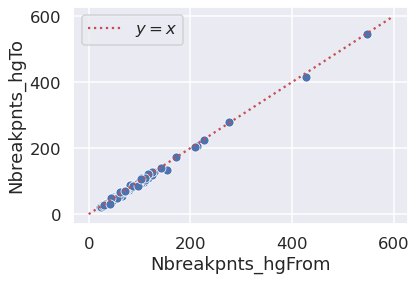

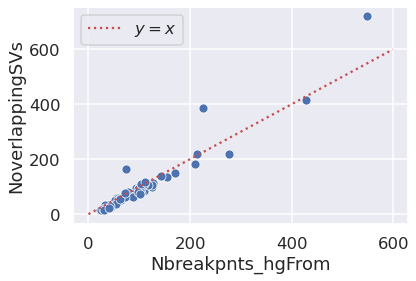

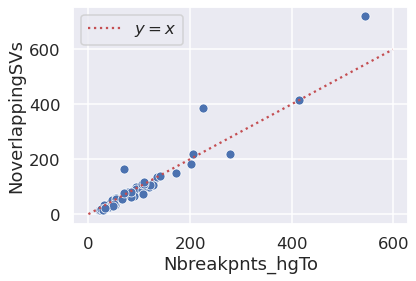

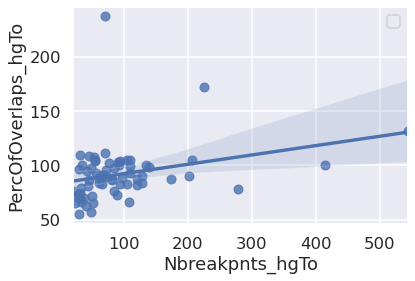

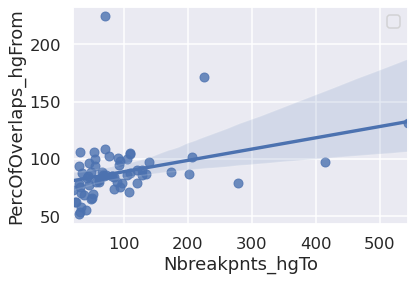

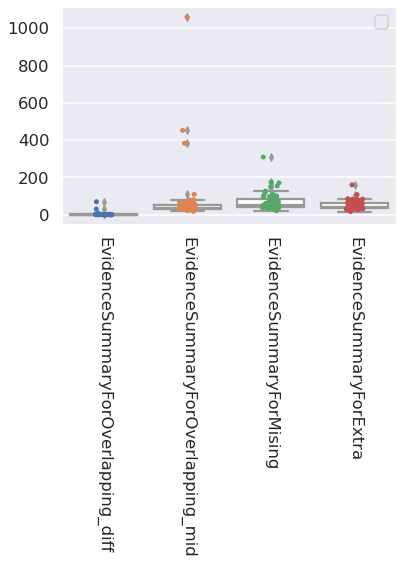

In [13]:
#df = df3_new #setting to five_liftover
df = df_current
fig, ax =pl.subplots()
sbs.scatterplot(data=df, x='Nbreakpnts_hgFrom', y='Nbreakpnts_hgTo')
ax.plot(range(0,600), range(0,600), "r:", label="$y=x$")
ax.legend(loc=0)

fig, ax =pl.subplots()
sbs.scatterplot(data=df, x='Nbreakpnts_hgFrom', y='NoverlappingSVs')
ax.plot(range(0,600), range(0,600), "r:", label="$y=x$")
ax.legend(loc=0)

fig, ax =pl.subplots()
sbs.scatterplot(data=df, x='Nbreakpnts_hgTo', y='NoverlappingSVs')
ax.plot(range(0,600), range(0,600), "r:", label="$y=x$")
ax.legend(loc=0)

df.loc[:,'PercOfOverlaps_hgFrom'] = df['NoverlappingSVs']/df['Nbreakpnts_hgFrom']*100
df.loc[:,'PercOfOverlaps_hgTo'] = df['NoverlappingSVs']/df['Nbreakpnts_hgTo']*100
df = df[~df['PercOfOverlaps_hgFrom'].isnull()]
df.sample(10)
fig, ax =pl.subplots()
sbs.regplot(data=df, x='Nbreakpnts_hgTo', y='PercOfOverlaps_hgTo')
#ax.plot(range(0,600), range(0,600), "r:", label="$y=x$")
ax.legend(loc=0)

fig, ax =pl.subplots()
sbs.regplot(data=df, x='Nbreakpnts_hgTo', y='PercOfOverlaps_hgFrom')
#ax.plot(range(0,600), range(0,600), "r:", label="$y=x$")
ax.legend(loc=0)
#ax.set_ylabel()

fig, ax =pl.subplots()
sbs.boxplot(data=df[['EvidenceSummaryForOverlapping_diff',
       'EvidenceSummaryForOverlapping_mid','EvidenceSummaryForMising','EvidenceSummaryForExtra']],color='w')
sbs.stripplot(data=df[['EvidenceSummaryForOverlapping_diff',
       'EvidenceSummaryForOverlapping_mid','EvidenceSummaryForMising','EvidenceSummaryForExtra']])
#ax.plot(range(0,600), range(0,600), "r:", label="$y=x$")
ax.legend(loc=0)
ax.set_xticklabels(['EvidenceSummaryForOverlapping_diff',
       'EvidenceSummaryForOverlapping_mid','EvidenceSummaryForMising','EvidenceSummaryForExtra'], rotation=-90)

In [14]:
print("percentage of breakpoints in hg19 that overlaps those from hg38 = ",(df['NoverlappingSVs']/df['Nbreakpnts_hgFrom']).mean())
print("percentage of breakpoints in hg38 that overlaps those from hg19 = ",(df['NoverlappingSVs']/df['Nbreakpnts_hgTo']).mean())

percentage of breakpoints in hg19 that overlaps those from hg38 =  0.8809472093804751
percentage of breakpoints in hg38 that overlaps those from hg19 =  0.9193816121775793


In [15]:
df[df['Nbreakpnts_hgFrom']>=234][['pair', 'NoverlappingSVs', 'Nbreakpnts_hgFrom', 'Nbreakpnts_hgTo']]

,pair,NoverlappingSVs,Nbreakpnts_hgFrom,Nbreakpnts_hgTo
6,SJASPS030015_D1_G1,218,277,279
45,SJBT030073_D1_G1,417,428,415
52,SJOS030272_D1_G1,719,548,545


In [16]:
df.loc[:,df.columns[1:]].mean()

Nbreakpnts_hgFrom                     96.578125
Nbreakpnts_hgTo                       93.578125
NoverlappingSVs                       92.531250
Noverlapping_match_type               92.390625
Noverlapping_discordant_type           0.140625
EvidenceSummaryForOverlapping_diff     2.363082
EvidenceSummaryForOverlapping_mid     70.034567
Nmissing                              18.828125
EvidenceSummaryForMising              69.277326
Nextra                                15.718750
EvidenceSummaryForExtra               49.831151
PercOfOverlaps_hgFrom                 88.094721
PercOfOverlaps_hgTo                   91.938161
dtype: float64

In [17]:
df[df['Nbreakpnts_hgFrom']==116]

,pair,Nbreakpnts_hgFrom,Nbreakpnts_hgTo,NoverlappingSVs,Noverlapping_match_type,Noverlapping_discordant_type,EvidenceSummaryForOverlapping_diff,EvidenceSummaryForOverlapping_mid,Nmissing,EvidenceSummaryForMising,Nextra,EvidenceSummaryForExtra,PercOfOverlaps_hgFrom,PercOfOverlaps_hgTo
7,SJALCL030011_D1_G1,116,110,102,102,0,0.309472,37.857054,20,56.29941,14,38.607439,87.931034,92.727273


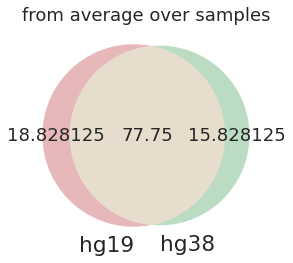

In [20]:
# Use the venn2 function
Noverlap = df.loc[:,df.columns[1:]].mean()['Nbreakpnts_hgFrom'] - df.loc[:,df.columns[1:]].mean()['Nmissing'] #or df.loc[:,df.columns[1:]].mean()['Nbreakpnts_hgTo'] - df.loc[:,df.columns[1:]].mean()['Nextra']
venn2(subsets = (df.loc[:,df.columns[1:]].mean()['Nbreakpnts_hgFrom']-Noverlap, df.loc[:,df.columns[1:]].mean()['Nbreakpnts_hgTo']-Noverlap, Noverlap), set_labels = ('hg19', 'hg38'))
pl.title("from average over samples")
pl.show()

# Discordant-rate
* Overlapping = coords AND strands
* Missing = SVs found using hg19 but do not overlap any in hg38
* Extra = SVs found using hg38 but do not overlap any in hg19
* Match = overlapping AND sv-types match
* Discordant = Extra OR Missing OR overlapping but different SV-types
* overlapping but different SV-types is rare (1-2 SVs and only in 3 sample-pairs)
* Discordant-rate = Discordant/(Extra+ Missing+ Overlapping)


count    64.000000
mean      0.322143
std       0.130420
min       0.096734
25%       0.236243
50%       0.286447
75%       0.400467
max       0.652174
Name: discordant-rate, dtype: float64


(0.1, 0.7)

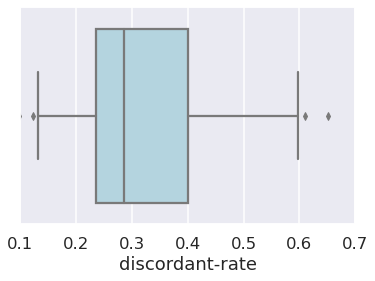

In [22]:
discordant = df['Nmissing']+df['Nextra']+df['Noverlapping_discordant_type']
match = df['NoverlappingSVs']-df['Noverlapping_discordant_type']
df.loc[:,'discordant-rate'] = discordant/(df['Nmissing']+df['Nextra']+df['NoverlappingSVs'])
print(df['discordant-rate'].describe())
#df['discordant-rate'].plot(kind='box')
fig,ax=pl.subplots()
sbs.boxplot(data = df, x='discordant-rate', color='lightblue', whis=[2.5,97.5])
ax.set_xlim(0.1,0.7)

In [24]:
(964+1144)/(5922+964+1144)

0.2625155666251557

* Two questions for each sample from the 64: (study the locations) of those that are not overlapping
1. are the new breakoints (hg38 not in hg19) in regions that did not map in hg19?
2. where are the missing breakpoints (hg19 not in hg38) located (chr/..etc) and is these locations consistent across samples?

/home/ralsallaq/miniconda3/envs/myenv/lib/python3.9/site-packages/seaborn/distributions.py:2557: FutureWarning: `distplot` is a deprecated function and will be removed in a future version. Please adapt your code to use either `displot` (a figure-level function with similar flexibility) or `histplot` (an axes-level function for histograms).
  warnings.warn(msg, FutureWarning)
/home/ralsallaq/miniconda3/envs/myenv/lib/python3.9/site-packages/seaborn/distributions.py:2557: FutureWarning: `distplot` is a deprecated function and will be removed in a future version. Please adapt your code to use either `displot` (a figure-level function with similar flexibility) or `histplot` (an axes-level function for histograms).
  warnings.warn(msg, FutureWarning)


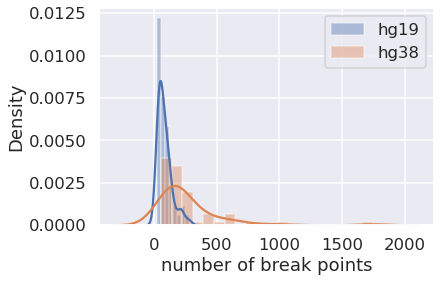

In [20]:
fig, ax = pl.subplots()
sbs.distplot(df['Nbreakpnts_hgFrom'], label='hg19')
sbs.distplot(df['Nbreakpnts_hgTo'], label='hg38')
ax.set_xlabel("number of break points")
ax.legend()

### Navigating for each sample missing (in hg19 not in hg38) and extra (in hg38 not in hg19) breakpoints
* The overlapping breakpoints using "both" and "strandedness" are saved under bedpe_comp_hg19_liftto_hg38/wliftover_both_samestrand/\\$PAIRNAME
* The extra breakpoints (in hg38 but not in hg19) are under bedpe_comp_hg19_liftto_hg38/wliftover_extra/\\$PAIRNAME
* The missing breakpoints (in hg19 but not in hg38) are under bedpe_comp_hg19_liftto_hg38/wliftover_missing/\\$PAIRNAME
* The total breakpoints for hg19 are under bedpe_hg19_leftTo_hg38/\\$PAIRNAME_hg19lo
* The total breakpoints for hg38 are under bedpe/\\$PAIRNAME_hg38

In [19]:
ls analysis/bedpe_comp_hg19_to_hg38

SJALCL030011_D1_G1_wliftover_both_samestrand.dbedpe*
SJALCL030011_D1_G1_wliftover_extra.bedpe*
SJALCL030011_D1_G1_wliftover_missing.bedpe*
SJAML001417_D1_G1_wliftover_both_samestrand.dbedpe*
SJAML001417_D1_G1_wliftover_extra.bedpe*
SJAML001417_D1_G1_wliftover_missing.bedpe*
SJAML030004_D1_G1_wliftover_both_samestrand.dbedpe*
SJAML030004_D1_G1_wliftover_extra.bedpe*
SJAML030004_D1_G1_wliftover_missing.bedpe*
SJAML030006_D1_G1_wliftover_both_samestrand.dbedpe*
SJAML030006_D1_G1_wliftover_extra.bedpe*
SJAML030006_D1_G1_wliftover_missing.bedpe*
SJAML030077_D1_G1_wliftover_both_samestrand.dbedpe*
SJAML030077_D1_G1_wliftover_extra.bedpe*
SJAML030077_D1_G1_wliftover_missing.bedpe*
SJAML030297_D1_G1_wliftover_both_samestrand.dbedpe*
SJAML030297_D1_G1_wliftover_extra.bedpe*
SJAML030297_D1_G1_wliftover_missing.bedpe*
SJASPS030009_D1_G1_wliftover_both_samestrand.dbedpe*
SJASPS030009_D1_G1_wliftover_extra.bedpe*
SJASPS030009_D1_G1_wliftover_missing.bedpe*
SJASPS030015_D1_G1_wliftover_both_samestra

In [24]:
import glob
import os
loc="./"
totBr_hg19Fs = sorted(glob.glob(loc+"analysis/bedpe_hg19_to_hg38/SJ*_hg19.bedpe"))
pairs = [os.path.basename(f).split("_hg19.bedpe")[0] for f in totBr_hg19Fs]
totBr_hg38Fs = sorted(glob.glob(loc+"analysis/bedpe_hg19_to_hg38/SJ*_hg38.bedpe"))
overlapFs = sorted(glob.glob(loc+"analysis/bedpe_comp_hg19_to_hg38/SJ*_wliftover_both_samestrand*.dbedpe"))
missingFs = sorted(glob.glob(loc+"analysis/bedpe_comp_hg19_to_hg38/SJ*_wliftover_missing.bedpe"))
extraFs = sorted(glob.glob(loc+"analysis/bedpe_comp_hg19_to_hg38/SJ*_wliftover_extra.bedpe"))

In [25]:
###make sure the files identically ordered 
for f1,f2 in zip(totBr_hg19Fs,overlapFs):
    assert(os.path.basename(f1).split("_hg19")[0]==os.path.basename(f2).split("_wliftover_both_samestrand")[0]),"not correctly ordered"
for f1,f2 in zip(totBr_hg19Fs,totBr_hg38Fs):
    assert(os.path.basename(f1).split("_hg19")[0]==os.path.basename(f2).split("_hg38")[0]),"not correctly ordered" 
for f1,f2 in zip(totBr_hg38Fs,missingFs):
    assert(os.path.basename(f1).split("_hg38")[0]==os.path.basename(f2).split("_wliftover_missing")[0]),"not correctly ordered" 
for f1,f2 in zip(totBr_hg38Fs,extraFs):
    assert(os.path.basename(f1).split("_hg38")[0]==os.path.basename(f2).split("_wliftover_extra")[0]),"not correctly ordered" 

In [26]:
overlapFs 

['./analysis/bedpe_comp_hg19_to_hg38/SJALCL030011_D1_G1_wliftover_both_samestrand.dbedpe',
 './analysis/bedpe_comp_hg19_to_hg38/SJAML001417_D1_G1_wliftover_both_samestrand.dbedpe',
 './analysis/bedpe_comp_hg19_to_hg38/SJAML030004_D1_G1_wliftover_both_samestrand.dbedpe',
 './analysis/bedpe_comp_hg19_to_hg38/SJAML030006_D1_G1_wliftover_both_samestrand.dbedpe',
 './analysis/bedpe_comp_hg19_to_hg38/SJASPS030009_D1_G1_wliftover_both_samestrand.dbedpe',
 './analysis/bedpe_comp_hg19_to_hg38/SJASPS030015_D1_G1_wliftover_both_samestrand.dbedpe',
 './analysis/bedpe_comp_hg19_to_hg38/SJBALL021900_D1_G1_wliftover_both_samestrand.dbedpe',
 './analysis/bedpe_comp_hg19_to_hg38/SJBALL237_D_G_wliftover_both_samestrand.dbedpe',
 './analysis/bedpe_comp_hg19_to_hg38/SJCBF041_D_H_wliftover_both_samestrand.dbedpe',
 './analysis/bedpe_comp_hg19_to_hg38/SJDSRCT030010_D1_G1_wliftover_both_samestrand.dbedpe',
 './analysis/bedpe_comp_hg19_to_hg38/SJDSRCT030016_D1_G1_wliftover_both_samestrand.dbedpe',
 './analysi

In [27]:
### read files into data-frames
totBr_hg38 = [pd.read_csv(f, sep="\t", header=None, names=['chrom1', 'start1', 'end1', 'chrom2', 'start2', 'end2', 'name',
       'evidence', 'strand1', 'strand2', 'cover1', 'cover2']) for f in totBr_hg38Fs]
totBr_hg19 = [pd.read_csv(f, sep="\t", header=None, names=['chrom1', 'start1', 'end1', 'chrom2', 'start2', 'end2', 'name',
       'evidence', 'strand1', 'strand2', 'cover1', 'cover2']) for f in totBr_hg19Fs]
###### the overlap is calculated with -a as hg19 and -b is hg38
print("the overlap is calculated with -a as hg19 and -b is hg38 so the first 10 columns are for hg19 and the second 10 are for hg38")
names_a=[n+"_hg19" for n in ['chrom1', 'start1', 'end1', 'chrom2', 'start2', 'end2', 'name',
       'evidence', 'strand1', 'strand2']]
names_b=[n+"_hg38" for n in ['chrom1', 'start1', 'end1', 'chrom2', 'start2', 'end2', 'name',
       'evidence', 'strand1', 'strand2']]
overlap = [pd.read_csv(f, sep="\t", header=None,names=names_a+names_b) if  os.stat(f).st_size > 0 else pd.DataFrame(columns=names_a+names_b) for f in overlapFs]
missing = [pd.read_csv(f, sep="\t", header=None,names=names_a) if  os.stat(f).st_size > 0 else pd.DataFrame(columns=names_a) for f in missingFs]
extra = [pd.read_csv(f, sep="\t", header=None,names=names_a) if  os.stat(f).st_size > 0 else pd.DataFrame(columns=names_a) for f in extraFs]

the overlap is calculated with -a as hg19 and -b is hg38 so the first 10 columns are for hg19 and the second 10 are for hg38


In [28]:
overlap[0].head()

,chrom1_hg19,start1_hg19,end1_hg19,chrom2_hg19,start2_hg19,end2_hg19,name_hg19,evidence_hg19,strand1_hg19,strand2_hg19,chrom1_hg38,start1_hg38,end1_hg38,chrom2_hg38,start2_hg38,end2_hg38,name_hg38,evidence_hg38,strand1_hg38,strand2_hg38
0,chr1,64348695,64348696,chr3,180272153,180272154,CTX,27.129320,+,+,chr1,64348695,64348696,chr3,180272153,180272154,CTX,30.199338,+,+
1,chr1,150866279,150866280,chr8,42959437,42959438,CTX,32.863353,+,-,chr1,150866279,150866280,chr8,42959437,42959438,CTX,33.763886,+,-
2,chr2,29224735,29224736,chr5,171392571,171392572,CTX,31.400637,+,-,chr2,29224735,29224736,chr5,171392566,171392567,CTX,36.083237,+,-
3,chr2,29224735,29224736,chr5,171392571,171392572,CTX,31.400637,+,-,chr2,29224735,29224736,chr5,171392571,171392572,CTX,37.788887,+,-
4,chr2,29224735,29224736,chr5,171392571,171392572,CTX,31.400637,+,-,chr5,171392571,171392572,chr2,29224735,29224736,CTX,37.788887,+,-


In [29]:
len(overlap) == len(totBr_hg19) == len(totBr_hg38) == len(missing) ==len(extra)

True

In [30]:
pairs[0]

'SJALCL030011_D1_G1'

- Are there any common missing breakpoints?
- Are there any common extra breakpoints?

In [31]:
 extra[0]

,chrom1_hg19,start1_hg19,end1_hg19,chrom2_hg19,start2_hg19,end2_hg19,name_hg19,evidence_hg19,strand1_hg19,strand2_hg19
0,chr1,28166418,28166419,chr6,32449946,32449947,CTX,35.213634,-,+
1,chr1,39500670,39500671,chr10,82753946,82753947,CTX,46.475800,-,+
2,chr1,40376253,40376254,chr15,78607419,78607420,CTX,43.497126,+,+
3,chr1,51465693,51465694,chr15,49277124,49277125,CTX,39.115214,+,+
4,chr1,60598604,60598605,chr18,37863841,37863842,CTX,30.199338,+,+
...,...,...,...,...,...,...,...,...,...,...
275,chrX,70812221,70812222,chr15,29213119,29213120,CTX,40.693980,+,+
276,chrX,104252445,104252446,chr10,98888129,98888130,CTX,41.352146,-,+
277,chrX,117582178,117582179,chr9,104690355,104690356,CTX,44.955534,-,+
278,chrX,119085119,119085120,chr18,23408915,23408916,CTX,48.373546,-,+


## counts of SVs in each sample by type and by set (overlapping/missing/extra) 

55.2962962962963

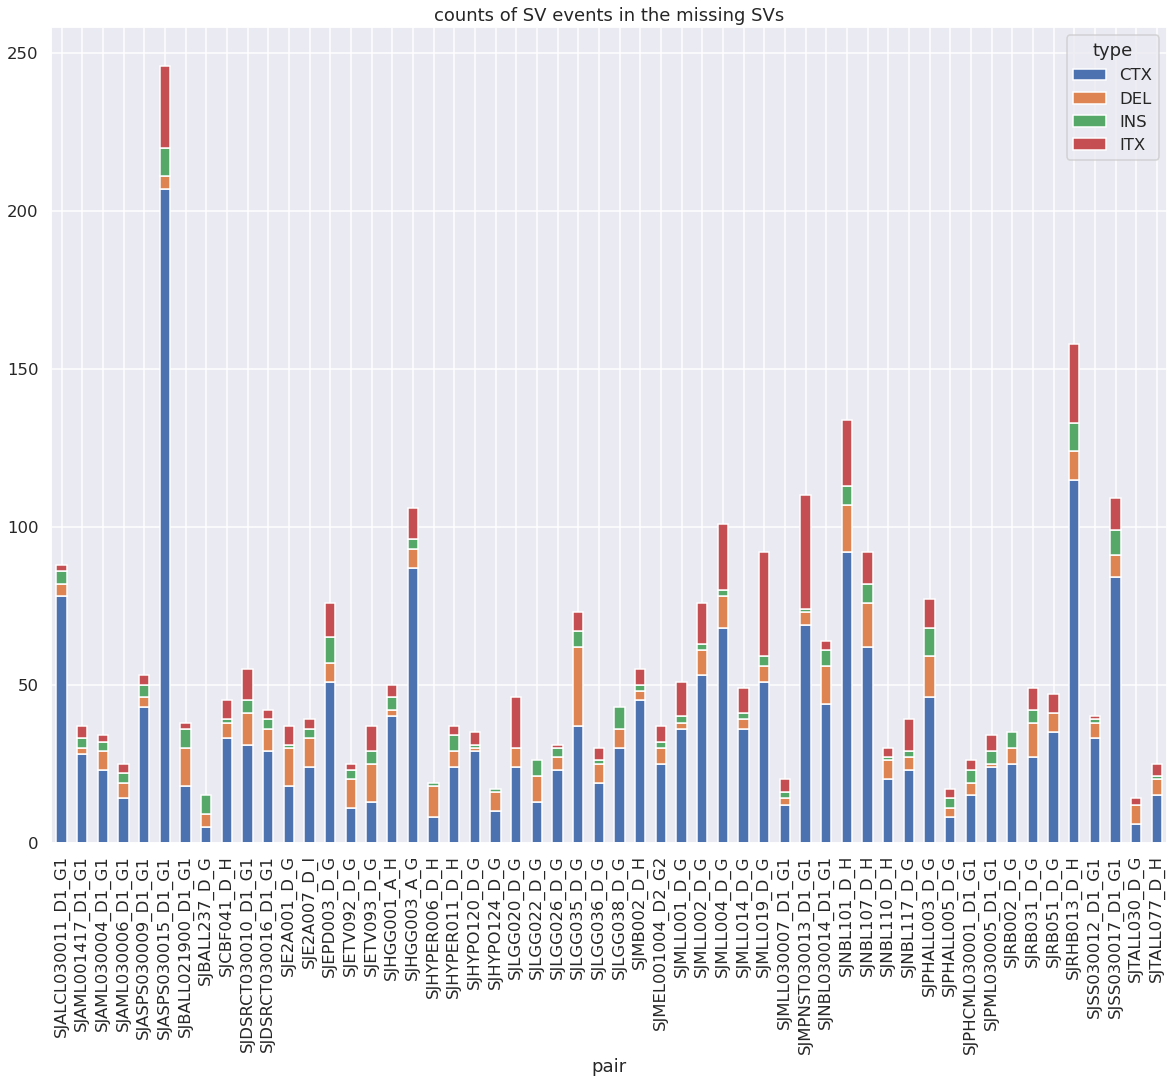

In [32]:
counts_of_events_dfs = [df_['name_hg19'].value_counts() for df_ in missing]

#sbs.countplot(counts_of_events_dfs[0].T)
df_type_freq = pd.DataFrame(index=pairs,columns=['CTX', 'INS', 'ITX', 'DEL'])
k=0
for i,p in enumerate(pairs):
    for t,f in counts_of_events_dfs[i].iteritems():
        df_type_freq.loc[k,'pair'] = p
        df_type_freq.loc[k,'freq'] = f
        df_type_freq.loc[k,'type'] = t
        k = k+1

fig, ax = pl.subplots(figsize=(20,15))
df_plot = df_type_freq.groupby(['pair', 'type']).sum().reset_index().pivot(columns='type', index='pair', values='freq')
df_plot.plot(kind='bar', stacked=True, ax=ax)
ax.set_title("counts of SV events in the missing SVs")
df_plot.sum(axis=1).mean()

240.35185185185185

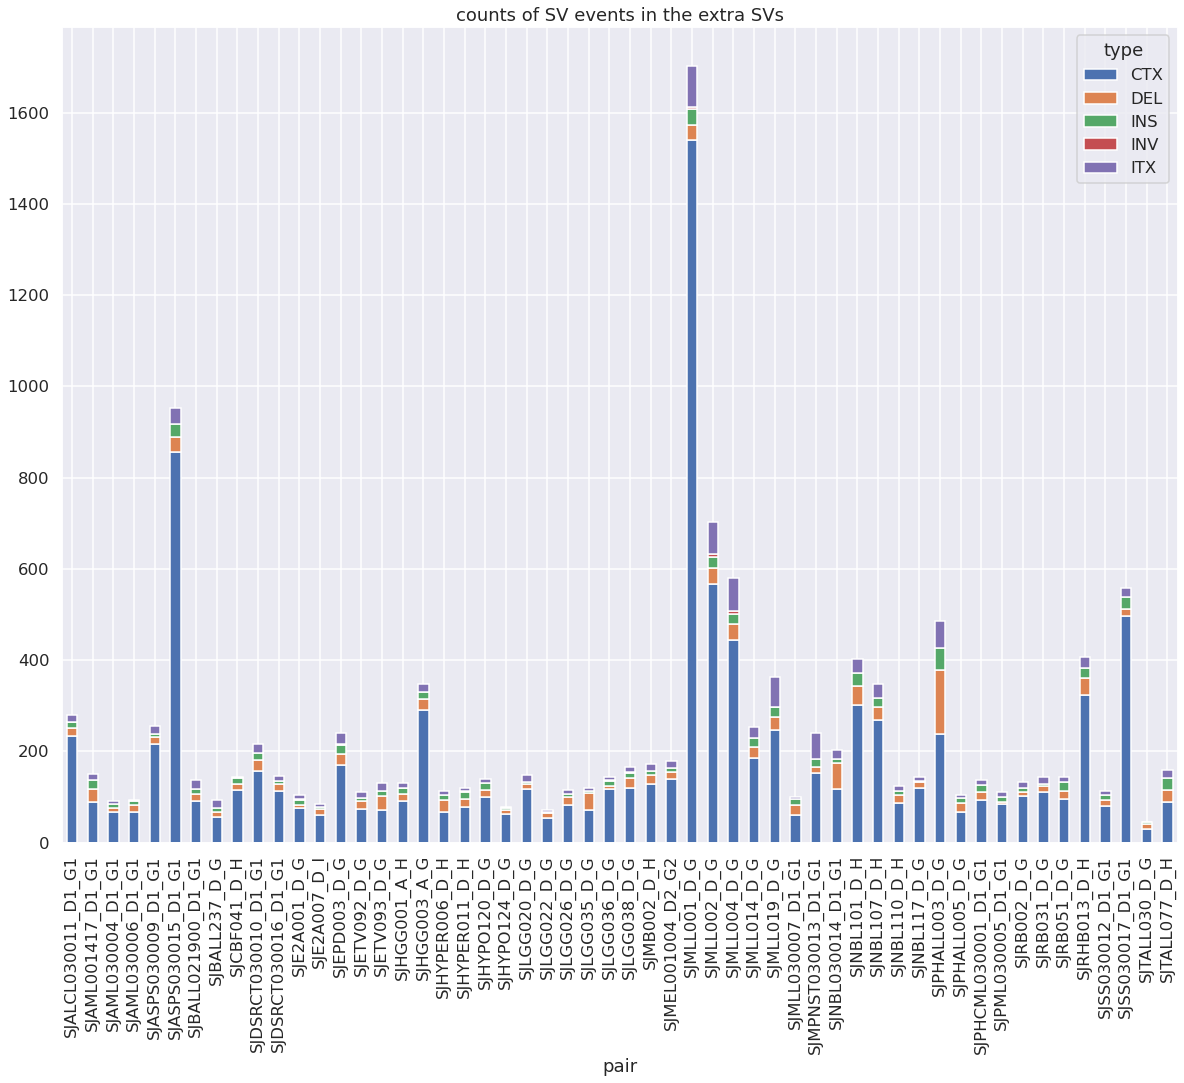

In [33]:
counts_of_events_dfs = [df_['name_hg19'].value_counts() for df_ in extra]

#sbs.countplot(counts_of_events_dfs[0].T)
df_type_freq = pd.DataFrame(index=pairs,columns=['CTX', 'INS', 'ITX', 'DEL'])
k=0
for i,p in enumerate(pairs):
    for t,f in counts_of_events_dfs[i].iteritems():
        df_type_freq.loc[k,'pair'] = p
        df_type_freq.loc[k,'freq'] = f
        df_type_freq.loc[k,'type'] = t
        k = k+1

fig, ax = pl.subplots(figsize=(20,15))
df_plot = df_type_freq.groupby(['pair', 'type']).sum().reset_index().pivot(columns='type', index='pair', values='freq')
df_plot.plot(kind='bar', stacked=True, ax=ax)
ax.set_title("counts of SV events in the extra SVs")
df_plot.sum(axis=1).mean()

### Do we see the same pattern in the overlaps?

36.148148148148145

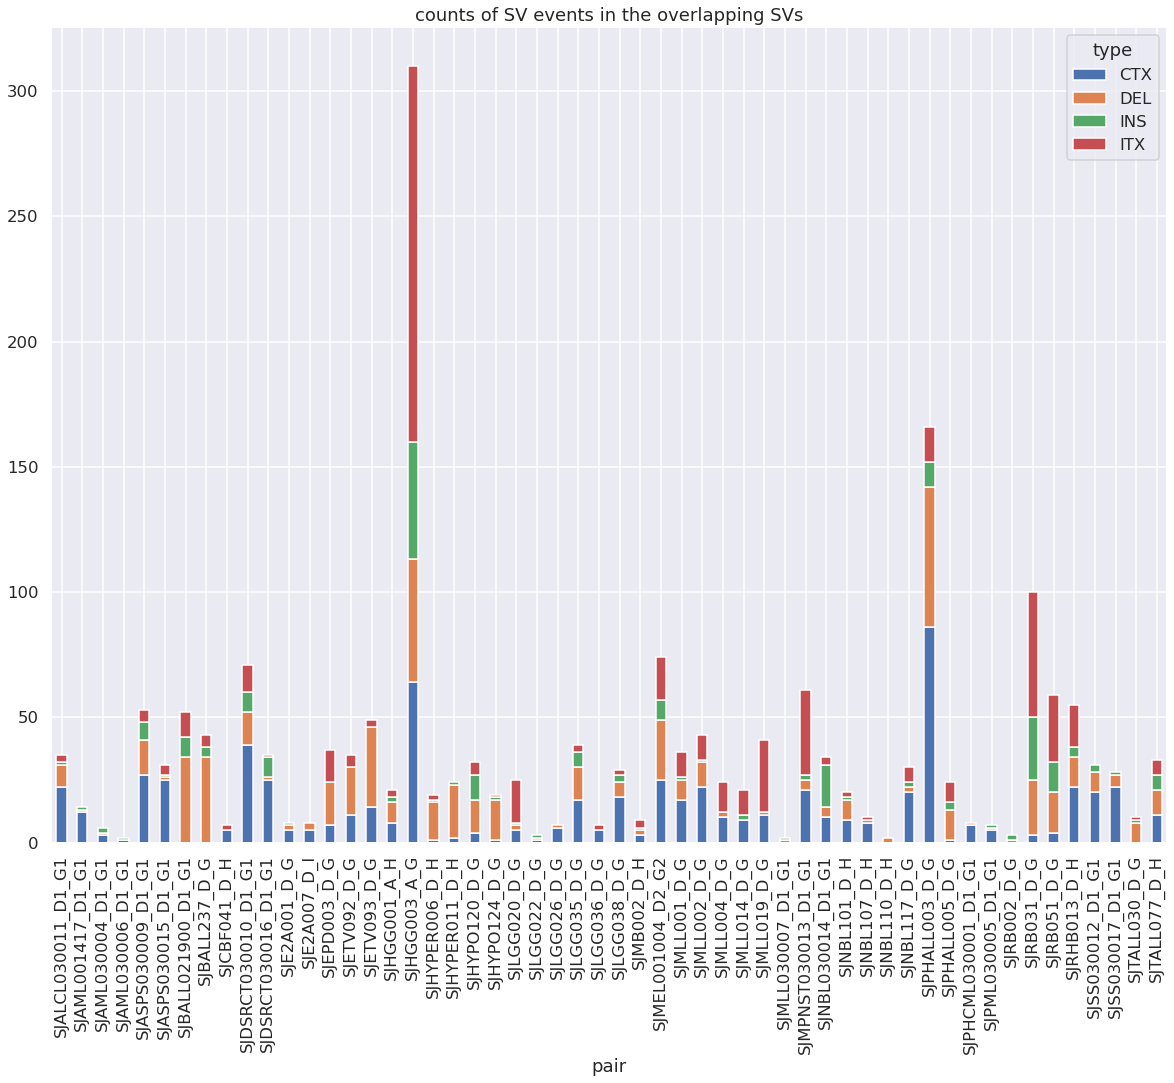

In [34]:
overlap[4]['name_hg38'].value_counts()
counts_of_events_dfs = [df_['name_hg38'].value_counts() for df_ in overlap]
#sbs.countplot(counts_of_events_dfs[0].T)
df_type_freq = pd.DataFrame(index=pairs,columns=['CTX', 'INS', 'ITX', 'DEL'])
k=0
for i,p in enumerate(pairs):
    for t,f in counts_of_events_dfs[i].iteritems():
        df_type_freq.loc[k,'pair'] = p
        df_type_freq.loc[k,'freq'] = f
        df_type_freq.loc[k,'type'] = t
        k = k+1

fig, ax = pl.subplots(figsize=(20,15))
df_plot = df_type_freq.groupby(['pair', 'type']).sum().reset_index().pivot(columns='type', index='pair', values='freq')
df_plot.plot(kind='bar', stacked=True, ax=ax)
ax.set_title("counts of SV events in the overlapping SVs")
df_plot.sum(axis=1).mean()

That the mean number of events is higher in the overlapping than that in the extra/missing data might suggest that there might be a trend in CREST discovery that when the number of events is higher CREST is more likely to be robust and does not diverge between the references. However the plot of % overlapped versus the number of breakpoints does not show this trend.
Next I will try to bin the genome and show the number of events along the genome (histogram)

In [35]:
df_plot

type,CTX,DEL,INS,ITX
pair,,,,
SJALCL030011_D1_G1,22.0,9.0,1.0,3.0
SJAML001417_D1_G1,12.0,1.0,1.0,NaN
SJAML030004_D1_G1,3.0,1.0,2.0,NaN
SJAML030006_D1_G1,1.0,NaN,1.0,NaN
SJASPS030009_D1_G1,27.0,14.0,7.0,5.0
SJASPS030015_D1_G1,25.0,1.0,1.0,4.0
SJBALL021900_D1_G1,NaN,34.0,8.0,10.0
SJBALL237_D_G,NaN,34.0,4.0,5.0
SJCBF041_D_H,5.0,NaN,NaN,2.0
